# Argentina programa 4.0 - Módulo 3: Aprendizaje Automático
---
# Ejercicios semana 2 - Ensembles, Pasting/Bagging, balance cesgo-varianza

In [1]:
# hacemos los imports de siempre

import matplotlib.pyplot as plt
import numpy as np

## **Ejercicio 1**

* Muestren cómo evolucionan los errores de entrenamiento y prueba en el conjunto de datos _Moons_ a medida que aumentamos el número de árboles en el _random forest_.

Arranquemos haciendo lunas

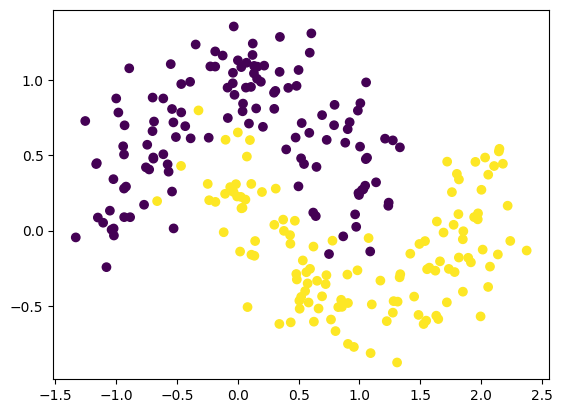

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.2, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y)

In [3]:
# separamos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Recodemos que el número de árboles es el número de estimadores definido en la variable `n_estimators`.

Para ver como evolucionan los errores en los conjuntos de entrenamiento y prueba en función del número de árboles, haremos un bucle en esa variable. En este caso elegimos la exactitud como medida del error.

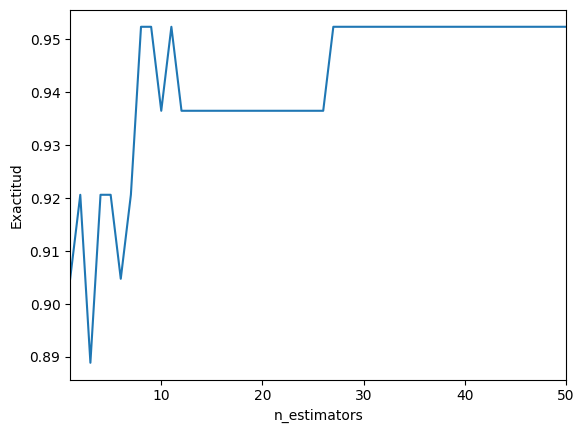

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(random_state=42)

# Rango de valores de `n_estimators` para explorar.
min_estimators = 1
max_estimators = 50

error = []

for i in range(min_estimators, max_estimators + 1):
    forest.set_params(n_estimators=i)
    forest.fit(X_train, y_train)

    # Graba la exactitud para cada n_estimators
    exactitud = accuracy_score(y_test,forest.predict(X_test))
    error.append((i, exactitud))

# Genera el gráfico "Tasa de exactitud" vs. "n_estimators".
xs, ys = zip(*error)
plt.plot(xs, ys)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Exactitud")
plt.show()


## **Ejercicio 2**

* Entrenar un Clasificador de árbol de decisión (`DecisionTreeClassifier`) no regularizado (es decir, un árbol salvaje) en el conjunto de datos. Evalúe su rendimiento con la validación cruzada.
* Entrene ahora un `DecisionTreeClassifier`. Utilice la validación cruzada para encontrar los hiperparámetros óptimos.

**Consejo**: Reflexione sobre cuáles son los parámetros más relevantes a explorar (elija no más de tres).

* Registrar los mejores hiperparámetros.
* Entrene un Clasificador de bosque aleatorio (`RandomForestClassifier`) en el mismo conjunto de datos.
* De nuevo, utilice el CV para encontrar los hiperparámetros óptimos

**Consejo2**: recuerda que además de los parámetros del punto anterior, necesitarás optimizar N estimadores (`n_estimators`);

**Consejo3**: aquí se hace una pausa para el café.

* Compara los hiperparámetros obtenidos con cada método. ¿Puedes encontrarle sentido a lo que obtienes?
* Define un Árbol de Decisión con los parámetros optimizados para el Bosque Aleatorio. Entrénalo y evalúa su rendimiento en un conjunto de pruebas. ¿Qué ves? ¿Tiene sentido?

**Nota:** en todos los casos, utiliza la función `plot_tree` para ver los resultados.

In [31]:
# generamos otro conjunto de datos de lunas
X, y = make_moons(n_samples=250, noise=0.3, random_state=42)

# separamos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


### Árbol salvaje

In [32]:
from sklearn.tree import DecisionTreeClassifier

# para un arbol no regularizado, dejamos la profundidad libre
wild_tree_clf = DecisionTreeClassifier(random_state=42)
wild_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Visualicemos el resultado usando `plot_tree`

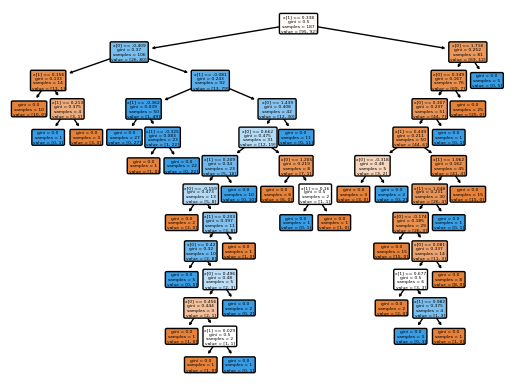

In [33]:
from sklearn.tree import plot_tree

plot_tree(wild_tree_clf,
          rounded=True,
          filled=True)
plt.show()


Como esperábamos, al no poner ninguna regularización, se crearon muchos niveles, de forma a separar todos los datos.

Ahora evaluemos el rendimiento con validación cruzada

In [34]:
from sklearn.model_selection import cross_val_score

exactitud = cross_val_score(wild_tree_clf, X, y, cv=5, scoring='accuracy')
print(exactitud)
print(exactitud.mean())
print(exactitud.std())

[0.82 0.76 0.76 0.92 0.86]
0.8240000000000001
0.061188234163113434


### Árbol regularizado

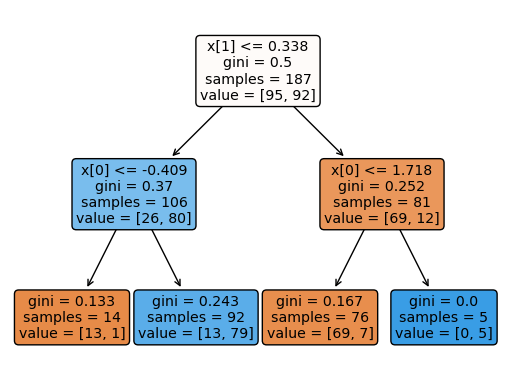

In [35]:
# aqui regularizamos imponiendo max_depth=2
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf.fit(X_train, y_train)

plot_tree(tree_clf,
          rounded=True,
          filled=True)
plt.show()

In [36]:
# evaluamos el rendimiento con validación cruzada
exactitud = cross_val_score(tree_clf, X, y, cv=5, scoring='accuracy')
print(exactitud)
print(exactitud.mean())
print(exactitud.std())

[0.88 0.74 0.82 0.88 0.86]
0.836
0.05276362383309169


Vemos que al regularizar, el modelo generaliza mejor, porque así evitamos mucho overfitting.

Ahora utilicemos _grid search_ con validación cruzada para encontrar los hiperparámetros óptimos. Vamos a explorar los siguientes parámetros: `max_depth` y `min_samples_split`.

In [37]:
from sklearn.model_selection import GridSearchCV

treecv = GridSearchCV(estimator=tree_clf,
                      param_grid={'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4, 5]},
                      cv=5,
                      scoring='accuracy')

# Ajusto. Recuerden usar los datos completos, porque CV ya va a separar internamente en 5 conjuntos de entrenamiento+prueba
treecv.fit(X, y)

# los mejores parámetros son
treecv.best_params_


{'max_depth': 5, 'min_samples_split': 2}

Veamos el rendimiento de ese árbol optimizado

In [38]:
# recordando que estamos usando la exactitud para medir el rendimiento del árbo
print(treecv.scoring)
print('la exactitud usando el árbol optimizado es:', treecv.best_score_)

accuracy
la exactitud usando el árbol optimizado es: 0.8400000000000001


### Bosque eleatório (_Random Forest_)

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# evaluamos el rendimiento con validación cruzada
exactitud = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(exactitud)
print(exactitud.mean())
print(exactitud.std())

[0.94 0.8  0.82 0.92 0.9 ]
0.876
0.05571355310873647


El resultado es significativamente mejor con _random forest_, ya que usa muchos árboles de decisión.

Ahora utilicemos _grid search_ con validación cruzada para encontrar los hiperparámetros óptimos. Además de `max_depth` y `min_samples_split`, vamos a agregar el parametro `n_estimators`


In [29]:
rfcv = GridSearchCV(estimator=rf,
                      param_grid={'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4, 5], 'n_estimators': [10, 20, 30, 40, 50]},
                      cv=5,
                      scoring='accuracy')

# Ajusto
rfcv.fit(X, y)

# los mejores parámetros son
rfcv.best_params_

{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 10}

Ahora veamos el rendimiento con el bosque aleatorio optimizado

In [30]:
# recordando que estamos usando la exactitud para medir el rendimiento del árbo
print(rfcv.scoring)
print('la exactitud usando el bosque aleatorio optimizado es:', rfcv.best_score_)

accuracy
la exactitud usando el bosque aleatorio optimizado es: 0.9


Compara los hiperparámetros obtenidos con cada método. ¿Puedes encontrarle sentido a lo que obtienes?

En en el bosque aleatório, el `max_depth` optimizado (7 en este caso) es  mayor al que obtuvimos para un único árbol aleatorio optimizado (5). Eso tiene sentido porque con un único árbol, con `max_depth` grande tenemos sobreajuste y, por lo tanto, bajo poder de generalización. Ya en el bosque aleatório como tenemos muchos árboles entrenados en sub-conjuntos distintos, queremos tener más variabilidad. O sea, conveiene ir a un `max_depth` mayor.

En resumen, el bosque aleatório usa el hecho de poder hacer un promedio de estimadores con **varianza** grande para obtener un **sesgo** pequeño.

### Define un Árbol de Decisión con los parámetros optimizados para el Bosque Aleatorio. Entrénalo y evalúa su rendimiento en un conjunto de pruebas. ¿Qué ves? ¿Tiene sentido?


In [47]:
# Vamos a definir un árbol de decisión con los parámetros optimizados del bosque aleatório del resultado anterior
# o sea, 'max_depth': 7, 'min_samples_split': 3

tree_bprf = DecisionTreeClassifier(max_depth = 7, min_samples_split = 3, random_state=42)

tree_bprf.fit(X_train, y_train)

exactitud_tree_bprf = accuracy_score(y_test,tree_bprf.predict(X_test))

# Definimos un bosque aleatorio con los parámetros optimizados del resultado anterior

rf_opt = RandomForestClassifier(max_depth = 7, min_samples_split = 3, n_estimators = 10, random_state=42)

rf_opt.fit(X_train, y_train)

exactitud_rf_opt = accuracy_score(y_test, rf_opt.predict(X_test))

print('La exactitud usando un árbol de decisión con los parámetros del bosque aleatorio optimizado es: ', exactitud_tree_bprf)
print('La exactitud del bosque aleatorio optimizado es: ', exactitud_rf_opt)

La exactitud usando un árbol de decisión con los parámetros del bosque aleatorio optimizado es:  0.873015873015873
La exactitud del bosque aleatorio optimizado es:  0.8412698412698413


Eso fue en una muestra de separación entrenamiento y testeo. Hagamos la comparación más correcta con CV

In [50]:
exactitud_tree_bprf = cross_val_score(tree_bprf, X, y, cv=5, scoring='accuracy')
exactitud_rfcv = cross_val_score(rf_opt, X, y, cv=5, scoring='accuracy')

print('La exactitud usando un árbol de decisión con los parámetros del bosque aleatorio optimizado es: ', exactitud_tree_bprf.mean())
print('La exactitud del bosque aleatorio optimizado es: ', exactitud_rfcv.mean())

La exactitud usando un árbol de decisión con los parámetros del bosque aleatorio optimizado es:  0.8240000000000001
La exactitud del bosque aleatorio optimizado es:  0.9


Vemos que, en promedio, el resultado con bosque aleatorio optimizado es bastante mejore que con un árbol de decisión con los mismos parámetros. Siquiendo la discusión que hicimos en el punto anterior, eso es lo que esperaríamos. Con un único árbol, es mejor regularizar, poniendo un `max_depth` pequeño. Ya con un bosque aleatório, es mejor tener una variabilidad mayor en cada estimador (o sea, mayor varianza), lo que se obtiene con un valor mayor de `max_depth`, ya que al hacer el promedio terminamos con un sesgo menor.

## Ejercicio 3

Usando el conjunto completo de Iris, o sea, con las 4 características, obtenga cuales características son las más importantes

Primero cargamos el dataset iris

In [19]:
from sklearn import datasets

iris=datasets.load_iris()

# Mantenemos todas las características
X = iris.data
y = iris.target

# miremos la dimensionalidad de los datos
print('dimensionalidad del conjunto iris:', X.shape, y.shape)
# como sabemos, son 4 características por flor en ese dataset y tenemos datos de 150 flores

# recordemos que los nombres de las características quedan grabados en
iris.feature_names

dimensionalidad del conjunto iris: (150, 4) (150,)


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Ahora usamos un clasificador de bosques aleatórios para determinar cuales son las características más importantes para predecir el target. Para eso, usaremos `SelectFromModel`

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# configuramos para seleccionar un subconjunto de características basados en bosques aleatorios
fs = SelectFromModel(RandomForestClassifier(n_estimators=1000))
# Fiteamos los datos
fs.fit(X, y)
# Ahora transformamos los datos de entrenamiento
X_fs = fs.transform(X)

## Veamos con cuantas features nos quedamos
print('datos seleccionados:', X_fs.shape)

datos seleccionados: (150, 2)


Vemos que han sido seleccionadas 2 características de las 4 del conjunto. Ahora podemos mirar cuáles fueron específicamente las características seleccionadas:

In [18]:
# El metodo get_support nos dice cuales han sido las características seleccionadas
selected_indices = fs.get_support()
selected_features = [feature for i, feature in enumerate(iris.feature_names) if selected_indices[i]]

print("características seleccionadas:", selected_features)

características seleccionadas: ['petal length (cm)', 'petal width (cm)']
